# Marvel Network Data

## Author: Oliver Gladfelter

### Date: Sep 10, 2020

In [1]:
import lxml.html as lh
import io
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests

In [8]:
data2 = pd.read_csv("marvel_data.csv")
del data2['Unnamed: 0']
import ast
data2['appearanceList'] = data2['appearanceList'].apply(ast.literal_eval)

In [9]:
data2.head(2)

,nameAndUniverse,centralityScore,url,appearances,appearanceList
0,Steven Rogers (Earth-616),0.772840,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,3604,"[All This and World War II, The Amazing Spider..."
1,Peter Parker (Earth-616),0.740318,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,4656,"[After Midnight, Amazing Spider-Man: The Big T..."


## Use List Intersections to Get Number of Common Comic Book Appearances, Construct a New DataFrame

In [5]:
name1 = []
name2 = []
numConnections = []

for num in range(0,len(data2)):
    #print(num)
    # only find intersection for all characters we haven't *already* 
    for num2 in range(num,len(data2)):
        if data2['nameAndUniverse'][num] == data2['nameAndUniverse'][num2]:
            continue
        name1.append(data2['nameAndUniverse'][num])
        name2.append(data2['nameAndUniverse'][num2])
        numConnections.append(len(set(data2['appearanceList'][num]).intersection(data2['appearanceList'][num2])))

network = pd.DataFrame({'name1':name1,'name2':name2,'numConnections':numConnections})

In [116]:
len(network)

8122465

In [8]:
network2 = network[network['numConnections'] != 0]
network2 = network2.reset_index()
del network2['index']

In [9]:
len(network2)

873005

In [10]:
network2.sort_values('numConnections',ascending=False).head()

,name1,name2,numConnections
17154,Benjamin Grimm (Earth-616),Jonathan Storm (Earth-616),1748
17151,Benjamin Grimm (Earth-616),Reed Richards (Earth-616),1743
22373,Reed Richards (Earth-616),Susan Storm (Earth-616),1663
22364,Reed Richards (Earth-616),Jonathan Storm (Earth-616),1653
17163,Benjamin Grimm (Earth-616),Susan Storm (Earth-616),1596


In [11]:
network2.to_csv("MarvelNumConnections.csv")

In [14]:
len(network['name1'].unique())

4028

## Use TSN-E to compute (x,y) coordinates for each character

In [19]:
# convert MarvelNumConnections.csv into matrix
network = network2.pivot_table(columns='name2', index='name1', values='numConnections').reset_index()

# fill missing connections with 0 - there are no common appearances
network = network.fillna(0)

# check network shape
print(network.shape)

# save name1 column, then drop it from matrix since it's non-numeric and can't go into TSN-E algorithm
characters = network[['name1']]
network = network.drop(['name1'], axis=1)

# TSNE stuff
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(network)

# sanity check: each character should have one set of tsne_features values
assert(len(tsne_features) == len(network))

# for each character, apply their (x,y) coordinates
characters['x'] = tsne_features[:,0]
characters['y'] = tsne_features[:,1]

## Viz Test

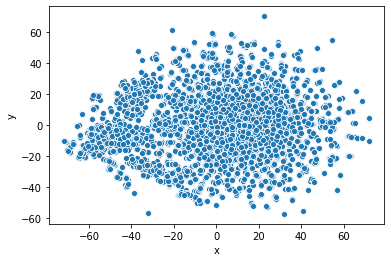

In [51]:
sns.scatterplot(x="x", y="y", data=characters)
plt.show()

## Some final data preparation before exporting for D3

In [59]:
def nameSimple(value):
    return re.sub("\(Earth-616\)","",value)

# remove earth-616 distinction from each name
characters['name'] = characters['name1'].apply(nameSimple)
del characters['name1']

# doing the same for original data set, so we can merge
data2['name'] = data2['nameAndUniverse'].apply(nameSimple)

# merge so I can grab # of appearances
data = characters.merge(data2)
data = data[['x', 'y', 'name', 'appearances']]

# sort
data = data.sort_values('appearances', ascending=False)

# save
data.to_csv("Marvel_characters_with_coords.csv", index=False)

In [81]:
top100 = data[0:100]

In [82]:
top100

,x,y,name,appearances
2694,-64.827324,-21.116581,Peter Parker,4656
3233,-65.331268,-20.446026,Steven Rogers,3604
218,-65.125847,-20.428740,Anthony Stark,3304
1590,-68.842613,-17.908754,James Howlett,3153
3348,-64.594124,-20.097712,Thor Odinson,2478
...,...,...,...,...
407,-64.200737,-7.496722,Blackagar Boltagon,445
322,-58.556816,17.384659,Balder Odinson,439
281,-53.878456,4.685630,Arthur Douglas,434
412,47.869690,-9.766297,Blaine Colt,433


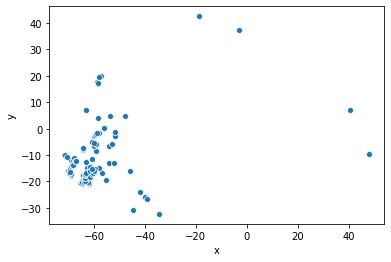

In [83]:
sns.scatterplot(x="x", y="y", data=top100)
plt.show()

In [86]:
top100.to_csv("top100.csv", index=False)

## Grabbing some extra info: avatar picture

In [4]:
data = pd.read_csv("Marvel_characters_with_coords.csv")

In [11]:
data = data.merge(data2)

In [13]:
data = data[['x','y','name','appearances','url']]

In [14]:
data

,x,y,name,appearances,url
0,-64.827324,-21.116581,Peter Parker,4656,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...
1,-65.331270,-20.446026,Steven Rogers,3604,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...
2,-65.125850,-20.428740,Anthony Stark,3304,http://marvel.wikia.com/wiki/Anthony_Stark_(Ea...
3,-68.842610,-17.908754,James Howlett,3153,http://marvel.wikia.com/wiki/James_Howlett_(Ea...
4,-64.594124,-20.097712,Thor Odinson,2478,http://marvel.wikia.com/wiki/Thor_Odinson_(Ear...
...,...,...,...,...,...
3680,10.365304,0.216396,Markus Ettlinger,10,http://marvel.wikia.com/wiki/Markus_Ettlinger_...
3681,39.090958,-6.546464,Hodari,10,http://marvel.wikia.com/wiki/Hodari_(Earth-616)
3682,4.030025,-2.344448,Criti Noll,10,http://marvel.wikia.com/wiki/Criti_Noll_(Earth...
3683,12.692588,-1.161417,Kendra Louise Price,10,http://marvel.wikia.com/wiki/Kendra_Louise_Pri...


In [26]:
data = data[data['appearances'] >= 75]

In [28]:
data = data.reset_index()
del data['index']

In [29]:
# following for loop saves images to a local folder for front end development
# each photo will be saved with a numerical ID. This new column helps connect characters to correct photos
data['pic_id'] = ''

for num in range(0,len(data)):
    
    url = data['url'][num]

    # open link to character page
    r = requests.get(url)

    try:
        soup = BeautifulSoup(r.content, "lxml")
        
        # find link to avatar picture
        image_url = soup.findAll("figure",{"class":"pi-item pi-image"})[0].find("a")['href']

        # open image, save to local folder
        img_data = requests.get(image_url).content
        with open("pictures/" + str(num) + ".jpg", 'wb') as handler:
            handler.write(img_data)  
            
        data['pic_id'][num] = num
        
    except:
        print("Error on: " + url)
        data['pic_id'][num] = -1

C:\Users\oglad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Error on: http://marvel.wikia.com/wiki/Janet_van_Dyne_(Earth-616)


C:\Users\oglad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Error on: http://marvel.wikia.com/wiki/May_Reilly_(Earth-616)
Error on: http://marvel.wikia.com/wiki/Ben_Urich_(Earth-616)
Error on: http://marvel.wikia.com/wiki/Jocasta_Vi_Quit%C3%A9ria_(Earth-616)
Error on: http://marvel.wikia.com/wiki/Nadia_Pym_(Earth-616)
Error on: http://marvel.wikia.com/wiki/Ego_(Earth-616)


In [ ]:
data['pic_id'][25] = 604
data['pic_id'][35] = 605
data['pic_id'][101] = 606
data['pic_id'][301] = 607
data['pic_id'][523] = 608
data['pic_id'][551] = 609

In [ ]:
data['url'][25] = "https://marvel.fandom.com/wiki/Janet_Van_Dyne_(Earth-616)"
data['url'][35] = "https://marvel.fandom.com/wiki/Maybelle_Reilly_(Earth-616)"
data['url'][101] = "https://marvel.fandom.com/wiki/Benjamin_Urich_(Earth-616)"
data['url'][301] = "https://marvel.fandom.com/wiki/Jocasta_Pym_(Earth-616)"
data['url'][523] = "https://marvel.fandom.com/wiki/Nadia_Van_Dyne_(Earth-616)"
data['url'][551] = "https://marvel.fandom.com/wiki/Egros_(Earth-616)"

In [44]:
data.to_csv("Top_Marvel_characters_With_Metadata.csv", index=False)

## name, alias

In [2]:
data = pd.read_csv("Top_Marvel_characters_With_Metadata.csv")

In [3]:
data.head(2)

,x,y,name,appearances,url,pic_id
0,-64.827324,-21.116581,Peter Parker,4656,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,0
1,-65.331270,-20.446026,Steven Rogers,3604,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,1


In [22]:
def getSuperheroName(link):
    """
    All character pages list the character's birth/legal name as its title
    For example, Captain America's main page is titled "Steven Rogers"
    This function collects each individual's superhero name
    """

    r=requests.get(link)
    if r.status_code != 200:
        return -1
    soup = BeautifulSoup(r.content, "lxml")
    
    return soup.find('h2',{'pi-item pi-item-spacing pi-title'}).text

def getFullName(link):
    """
    Several characters have nicknames. For example, we all know Ironman
    to be the superhero name of Tony Stark, but Stark's birth/legal name is
    "Anthony Stark", which is the name we originally collected. This function
    collects characters' full names, which include their nickname
    """
    
    r=requests.get(link)
    if r.status_code != 200:
        return -1
    soup = BeautifulSoup(r.content, "lxml")
    
    name = soup.find('div',{'class':'pi-data-value pi-font'}).text
    
    # Removing citation notation and leading space
    name = name.replace(" [1]","").strip(" ")
    name = name.replace("[1]","")
    name = name.replace(" [2]","")
    name = name.replace("[2]","")
    name = name.replace(" [3]","")
    return name.replace("[3]","")

def nickName(fullName):
    """
    Parses a nickname out of a full name, if a character has a nickname
    """
    
    if fullName == -1:
        return fullName
    
    # No listed nickname in full name
    if re.search("[\"\'](.{,})[\"\']",fullName) is None:
        return ""
    
    # Return nickname + last name
    nickName = re.search("[\"\'](.{,})[\"\']",fullName).group(1)
    lastName = fullName.split(" ")[-1]
    return nickName + " " + lastName

In [6]:
getSuperheroName(data['url'][1])

'Captain America'

In [7]:
getFullName(data['url'][1])

'Steven "Steve" Rogers'

In [9]:
nickName('Steven "Steve" Rogers')

'Steve Rogers'

In [23]:
data['superName'] = data['url'].apply(getSuperheroName)
data['fullName'] = data['url'].apply(getFullName)
data['nickName'] = data['fullName'].apply(nickName)

In [25]:
data.head(2)

,x,y,name,appearances,url,pic_id,superName,fullName,nickName
0,-64.827324,-21.116581,Peter Parker,4656,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,0,Spider-Man,Peter Benjamin Parker,
1,-65.331270,-20.446026,Steven Rogers,3604,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,1,Captain America,"Steven ""Steve"" Rogers",Steve Rogers


In [26]:
for num in range(0,len(data)):
    if data['nickName'][num] == "":
        data['nickName'][num] = data['name'][num]

C:\Users\oglad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
data.to_csv("Top_Marvel_characters_With_Metadata.csv", index=False)